### Parte II: Métodos No Supervisados

In [25]:
# Importamos librerías necesarias
import pandas as pd
import numpy as np

# Cargamos la base unificada del TP2 (ya filtrada por GBA)
df = pd.read_excel("baseGBA_unida.xlsx")

# Creamos las variables de edad y edad² 
df["edad"] = pd.to_numeric(df["CH06"], errors="coerce")
df["edad2"] = df["edad"] ** 2

# Creamos la variable de educ (años de educación)
def calcular_educacion(row):
    nivel = row["CH12"]
    finalizo = row["CH13"]
    ultimo = row["CH14"]

    if pd.isnull(nivel):
        return np.nan
    if finalizo == 1:
        if nivel == 1:  
            return 7
        elif nivel == 2:  
            return 12
        elif nivel == 3:  
            return 17
    if pd.notnull(ultimo):
        try:
            return int(ultimo)
        except:
            return np.nan
    return np.nan

df["educ"] = df.apply(calcular_educacion, axis=1)

# Creamos la variable de salario_semanal ajustando los ingresos de 2004 a valores de 2024
df["P47T"] = pd.to_numeric(df["P47T"], errors="coerce")
df["ingreso_ajustado"] = df.apply(lambda x: x["P47T"] * 25 if x["ANO4"] == 2004 else x["P47T"], axis=1)
df["salario_semanal"] = df["ingreso_ajustado"] / 4  # asumimos ingreso mensual

# Creamos la variable de horastrab sumando horas principales y secundarias
df["PP3E_TOT"] = pd.to_numeric(df["PP3E_TOT"], errors="coerce")
df["PP3F_TOT"] = pd.to_numeric(df.get("PP3F_TOT", 0), errors="coerce") 
df["horastrab"] = df[["PP3E_TOT", "PP3F_TOT"]].sum(axis=1)

# Nos quedamos solo con las variables necesarias
variables_finales = ["ANO4", "edad", "edad2", "educ", "salario_semanal", "horastrab"]
df_final = df[variables_finales].dropna()

# Guardamos la nueva base simplificada
df_final.to_excel("base_TP3_parte2.xlsx", index=False)

In [26]:
# Importamos las librerías que vamos a usar
import pandas as pd

# Cargamos la base simplificada
df = pd.read_excel("base_TP3_parte2.xlsx")

# Hacemos una copia para trabajar sobre ella
df_filtrada = df.copy()

# Filtramos registros con educ > 25 (años de educación no razonables)
df_filtrada = df_filtrada[df_filtrada["educ"] <= 25]

# Filtramos registros con salario_semanal negativo (no tiene sentido)
df_filtrada = df_filtrada[df_filtrada["salario_semanal"] >= 0]

# Filtramos registros con horastrab > 100 (límite razonable de horas trabajadas por semana)
df_filtrada = df_filtrada[df_filtrada["horastrab"] <= 100]

# Guardamos la nueva base final filtrada
df_filtrada.to_excel("base_TP3_limpia_definitiva.xlsx", index=False)

# Mostramos la cantidad de observaciones por año luego del filtrado
print("Observaciones por año luego del filtrado:")
print(df_filtrada["ANO4"].value_counts())

Observaciones por año luego del filtrado:
ANO4
2004    3760
2024    3439
Name: count, dtype: int64


1-)

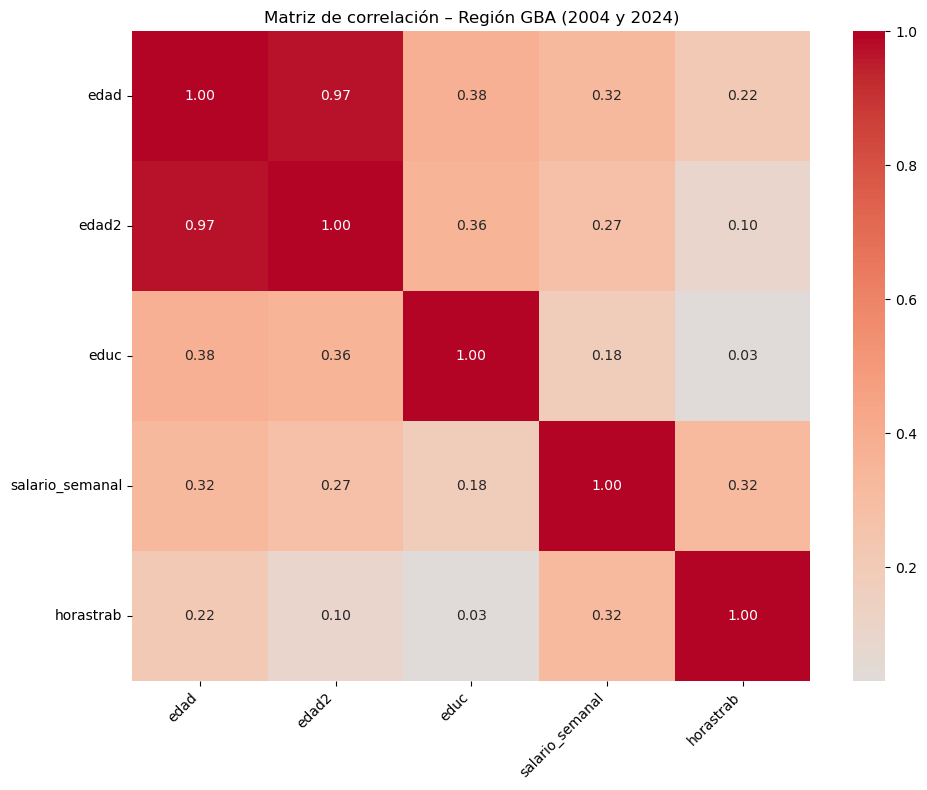

Matriz de correlación (toda la base)
                     edad     edad2      educ  salario_semanal  horastrab
edad             1.000000  0.966747  0.379520         0.323401   0.219061
edad2            0.966747  1.000000  0.359692         0.274726   0.096805
educ             0.379520  0.359692  1.000000         0.175413   0.030773
salario_semanal  0.323401  0.274726  0.175413         1.000000   0.315406
horastrab        0.219061  0.096805  0.030773         0.315406   1.000000


In [40]:
# Importamos las librerías que vamos a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Leemos el archivo de Excel con la base ya limpia y filtrada
df = pd.read_excel("base_TP3_limpia_definitiva.xlsx") 

# Variables pedidas en la consigna para la matriz de correlación
variables = ['edad', 'edad2', 'educ', 'salario_semanal', 'horastrab']
df_filtered = df[variables].copy()

# Calculamos la matriz de correlación sobre toda la base (2004 y 2024)
corr_total = df_filtered.corr()

# Graficamos la matriz de correlación con mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_total, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Matriz de correlación – Región GBA (2004 y 2024)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Mostramos también la matriz en consola
print("Matriz de correlación (toda la base)")
print(corr_total)

2-)

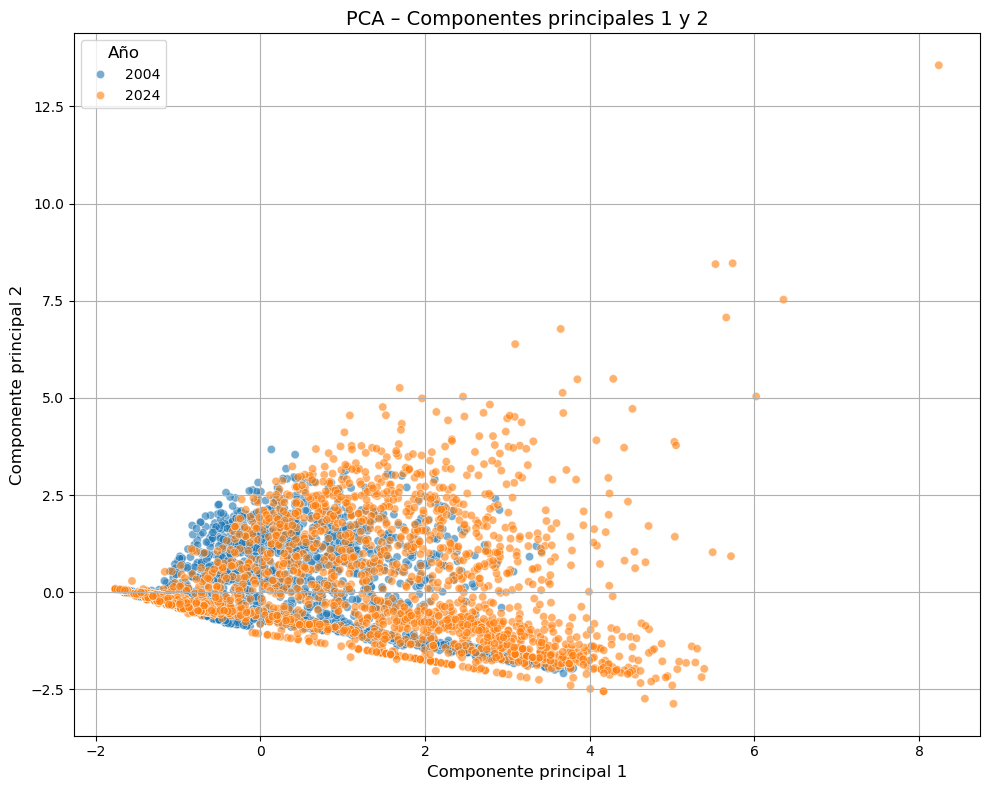

Varianza explicada por los componentes
[0.48382437 0.22594944]


In [38]:
# Importamos las librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Leemos la base limpia con las variables filtradas y estandarizadas
df = pd.read_excel("base_TP3_limpia_definitiva.xlsx")

# Seleccionamos las variables numéricas pedidas en la consigna
variables = ["edad", "edad2", "educ", "salario_semanal", "horastrab"]
X = df[variables].copy()

# Estandarizamos las variables (media 0 y desviación estándar 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creamos un nuevo DataFrame con los scores de cada observación
df_pca = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
df_pca["ANO4"] = df["ANO4"].values

# Graficamos los componentes principales en un gráfico de dispersión
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="ANO4", palette="tab10", alpha=0.6)
plt.title("PCA – Componentes principales 1 y 2", fontsize=14)
plt.xlabel("Componente principal 1", fontsize=12)
plt.ylabel("Componente principal 2", fontsize=12)
plt.legend(title="Año", title_fontsize=12, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostramos cuánta varianza explica cada componente
print("Varianza explicada por los componentes")
print(pca.explained_variance_ratio_)

3-)

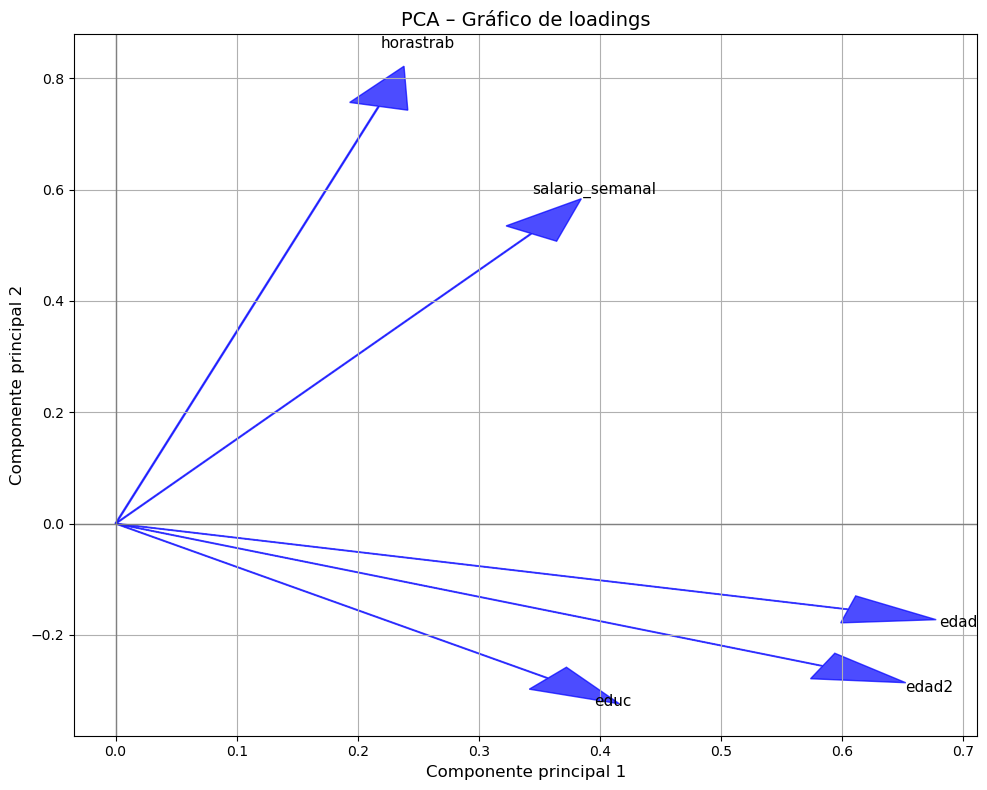

Cargas de cada variable sobre los componentes:
                      PC1       PC2
edad             0.605171 -0.154134
edad2            0.584061 -0.255836
educ             0.357040 -0.277788
salario_semanal  0.343413  0.521088
horastrab        0.217325  0.749728


In [42]:
# Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Leemos la base con las variables filtradas y estandarizadas
df = pd.read_excel("base_TP3_limpia_definitiva.xlsx")

# Seleccionamos las variables numéricas a usar en el PCA
variables = ["edad", "edad2", "educ", "salario_semanal", "horastrab"]
X = df[variables].copy()

# Estandarizamos las variables (media = 0, desvío estándar = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Obtenemos los loadings del PCA
loadings = pca.components_.T
var_names = variables

# Creamos el gráfico de flechas para visualizar los loadings
plt.figure(figsize=(10, 8))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# Dibujamos una flecha por cada variable en el espacio PC1 y PC2
for i, var in enumerate(var_names):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              color='blue', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, var,
             color='black', ha='center', va='center', fontsize=11)

# Etiquetamos los ejes y el gráfico
plt.title("PCA – Gráfico de loadings", fontsize=14)
plt.xlabel("Componente principal 1", fontsize=12)
plt.ylabel("Componente principal 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostramos los valores numéricos de los loadings
loadings_df = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=var_names)
print("Cargas de cada variable sobre los componentes:")
print(loadings_df)